<a href="https://colab.research.google.com/github/fjadidi2001/Artificial_Intelligence_Learning/blob/master/classification_using_svd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Data Loading and Preparation


11490434/11490434 [==============================] - 0s 0us/step
x_train shape: (784, 60000)
x_test shape: (784, 10000)


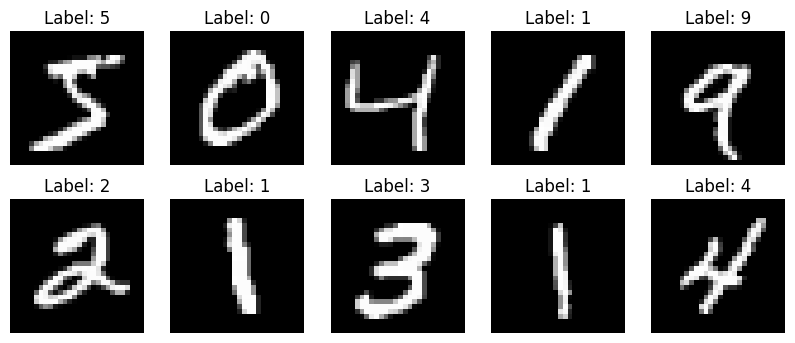

In [1]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape the data
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train = x_train.T
x_test = x_test.T

print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")

# Visualize some sample images
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[:, i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()


# Step 2: Performing SVD


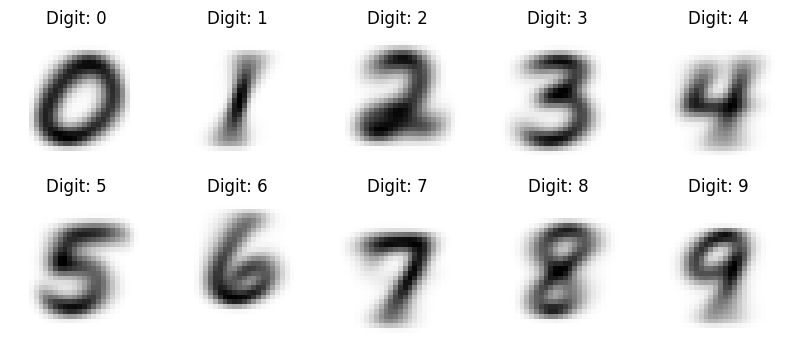

In [2]:
# Perform SVD on each digit
U = {}
S = {}
Vt = {}
digits = range(10)

for digit in digits:
    idx = np.where(y_train == digit)[0]
    X_digit = x_train[:, idx]
    U[digit], S[digit], Vt[digit] = np.linalg.svd(X_digit, full_matrices=False)

# Visualize the first singular vector (basis) for each digit
plt.figure(figsize=(10, 4))
for digit in digits:
    plt.subplot(2, 5, digit + 1)
    plt.imshow(U[digit][:, 0].reshape(28, 28), cmap='gray')
    plt.title(f"Digit: {digit}")
    plt.axis('off')
plt.show()


# Step 3: Projection and Classification


Classification accuracy: 9.33%


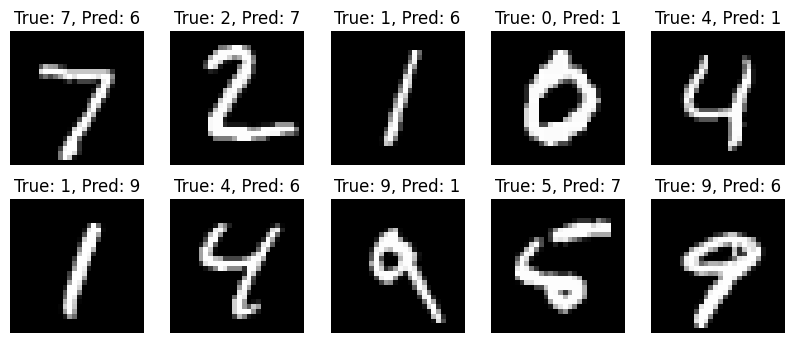

In [3]:
# Project test data onto the bases
projections = {}
for digit in digits:
    projections[digit] = np.dot(U[digit].T, x_test)

# Classify based on least squares residuals
y_pred = np.zeros(x_test.shape[1])

for i in range(x_test.shape[1]):
    residuals = {}
    for digit in digits:
        residual = np.linalg.norm(x_test[:, i] - np.dot(U[digit], projections[digit][:, i]))
        residuals[digit] = residual
    y_pred[i] = min(residuals, key=residuals.get)

# Calculate accuracy
accuracy = np.mean(y_pred == y_test) * 100
print(f"Classification accuracy: {accuracy:.2f}%")

# Visualize some classification results
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[:, i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {y_test[i]}, Pred: {int(y_pred[i])}")
    plt.axis('off')
plt.show()


# Step 1: Data Loading and Preparation


x_train shape: (784, 60000)
x_test shape: (784, 10000)


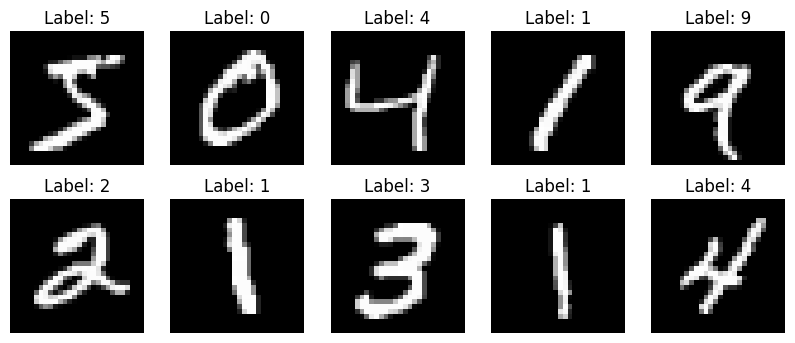

In [4]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape the data
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train = x_train.T
x_test = x_test.T

print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")

# Visualize some sample images
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[:, i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()


# Step 2: Performing SVD


U[0] shape: (784, 784)
S[0] shape: (784,)
Vt[0] shape: (784, 5923)


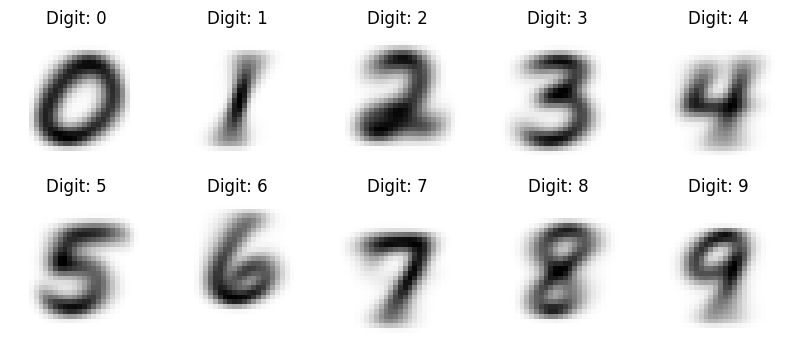

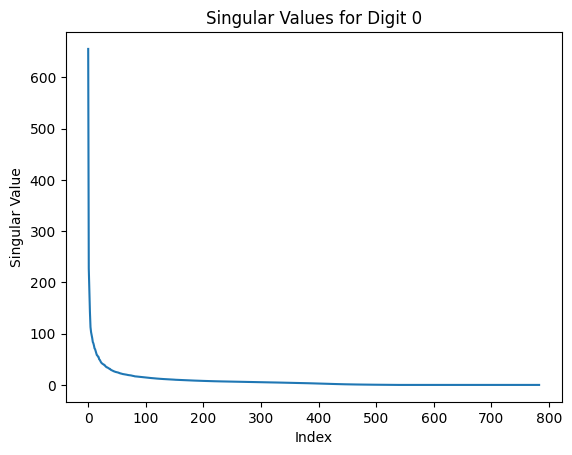

In [5]:
# Perform SVD on each digit
U = {}
S = {}
Vt = {}
digits = range(10)

for digit in digits:
    idx = np.where(y_train == digit)[0]
    X_digit = x_train[:, idx]
    U[digit], S[digit], Vt[digit] = np.linalg.svd(X_digit, full_matrices=False)

# Visualize U, S, and Vt matrices for one digit (e.g., digit 0)
digit = 0
print(f"U[{digit}] shape: {U[digit].shape}")
print(f"S[{digit}] shape: {S[digit].shape}")
print(f"Vt[{digit}] shape: {Vt[digit].shape}")

# Display the first singular vector (basis) for each digit
plt.figure(figsize=(10, 4))
for digit in digits:
    plt.subplot(2, 5, digit + 1)
    plt.imshow(U[digit][:, 0].reshape(28, 28), cmap='gray')
    plt.title(f"Digit: {digit}")
    plt.axis('off')
plt.show()

# Show singular values for digit 0
plt.figure()
plt.plot(S[0])
plt.title(f"Singular Values for Digit 0")
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.show()


# Step 3: Projection and Classification


In [7]:
# Project test data onto the bases
projections = {}
for digit in digits:
    projections[digit] = np.dot(U[digit].T, x_test)

# Classify based on least squares residuals
y_pred_test = np.zeros(x_test.shape[1])
for i in range(x_test.shape[1]):
    residuals = {}
    for digit in digits:
        residual = np.linalg.norm(x_test[:, i] - np.dot(U[digit], projections[digit][:, i]))
        residuals[digit] = residual
    y_pred_test[i] = min(residuals, key=residuals.get)

# Project train data onto the bases
projections_train = {}
for digit in digits:
    projections_train[digit] = np.dot(U[digit].T, x_train)

# Classify based on least squares residuals for train data
y_pred_train = np.zeros(x_train.shape[1])
for i in range(x_train.shape[1]):
    residuals = {}
    for digit in digits:
        residual = np.linalg.norm(x_train[:, i] - np.dot(U[digit], projections_train[digit][:, i]))
        residuals[digit] = residual
    y_pred_train[i] = min(residuals, key=residuals.get)
